In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker


In [2]:
class MSAAutoencoder(nn.Module):
    def __init__(self, seq_length, latent_dim=2):
        super(MSAAutoencoder, self).__init__()
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=21,out_channels=64,kernel_size=3,
            padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32,out_channels=16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16,out_channels=latent_dim, kernel_size=3, padding=1), # Cuello de botella
            nn.LayerNorm([latent_dim, seq_length]) #normaliza
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=latent_dim, out_channels=16, kernel_size=3,
            padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16,
            out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=21, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        x = self.encoder(x) # Extrae representaciones comprimidas
        x = self.decoder(x) # Reconstruye la salida
        return x

a) Escriba un código que permita levantar el alineamiento múltiple y convertirlo a
un tensor de dimensiones número de secuencias (N) x 21 canales (OHE) x longitud del
alineamiento múltiple (L), qué es lo que se va a utilizar como entrada para el entrenamiento en
baches.

In [3]:
def leer_fasta(filepath):
    secuencias = []
    for record in SeqIO.parse(filepath, "fasta"):
        secuencias.append(str(record.seq))
    return secuencias

def one_hot_encoding(secuencias, aminoacidos="ACDEFGHIKLMNPQRSTVWY-"):

    aa_to_index = {aa: idx for idx, aa in enumerate(aminoacidos)}
    ohe_matrices = []
    
    for secuencia in secuencias:
        ohe_matrix = np.zeros((len(aminoacidos), len(secuencia)), dtype=np.float32)
        for i, aa in enumerate(secuencia):
            if aa in aa_to_index:
                ohe_matrix[aa_to_index[aa], i] = 1.0
        ohe_matrices.append(ohe_matrix)
    
    return np.array(ohe_matrices)

def one_hot_to_AA(seq_one_hot, aminoacidos="ACDEFGHIKLMNPQRSTVWY-"):
    aa_to_index = {idx: aa for idx, aa in enumerate(aminoacidos)}
    secuencia = ""
    for i in range(len(seq_one_hot)):
        index = np.argmax(seq_one_hot[:, i])
        secuencia += aa_to_index[index]
    return secuencia

In [4]:
seqs = leer_fasta("NOPQ_cur.fasta")
seqs_one_hot = torch.tensor(one_hot_encoding(seqs), dtype=torch.float32)
print(seqs_one_hot.shape)

torch.Size([2009, 21, 203])


b) Escriba, por otro lado, un módulo(función) que le permita comparar dos secuencias y
calcular su similitud (por ejemplo utilizando una matriz de sustitucion tipo blossum) o identidad,
para evaluar la performance modelo. Recuerde que el autoencoder toma como entrada una
secuencia y genera como salida otra secuencia que debería ser igual a la de la entrada. Por lo
que dadas las N secuencias del MSA hay N pares (input-output) para comparar.

In [5]:
from Bio.Align import substitution_matrices

def calcular_similitud(seq1, seq2, matriz_sustitucion=substitution_matrices.load("BLOSUM62")):
    
    puntaje = 0
    
    for aa1, aa2 in zip(seq1, seq2):
        if (aa1, aa2) in matriz_sustitucion:
            puntaje += matriz_sustitucion[(aa1, aa2)]
        elif (aa2, aa1) in matriz_sustitucion:  # La matriz es simétrica
            puntaje += matriz_sustitucion[(aa2, aa1)]
    
    return puntaje


c) Entonces, primero para un modelo sin entrenar, y luego para diferentes modelos entrenados
corra todas los pares de secuencias con su programa de scoring y realice el histograma
correspondiente. Analice cómo cambia la performance del modelo cuando uno achica la
dimensión latente de 8, a 4, a 2 y hasta uno(1).

In [ ]:
my_nn = MSAAutoencoder(seq_length=seqs_one_hot.shape[2], latent_dim=2)

# Sin entrenar
out = my_nn(seqs_one_hot)
similitud = [[] for _ in range(5)]

for i in range(len(seqs)):
    similitud[0].append(calcular_similitud(seqs[i], one_hot_to_AA(out[i].detach().numpy())))

In [6]:
def train(network, optimizer, 
          criterion, 
          train_loader = None):
    
    network.train()
    batch_size = train_loader.batch_size
    total_loss = 0

    for batch_i, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
            
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [11]:
y_true_indices = torch.argmax(seqs_one_hot, dim=1)
dataset = TensorDataset(seqs_one_hot, y_true_indices)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [50]:
dims = [1, 2, 4, 8]
losses = []
epochs = 50
for i,dim in enumerate(dims):
    my_nn = MSAAutoencoder(seq_length=seqs_one_hot.shape[2], latent_dim=dim)
    optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        loss = train(my_nn, optimizer, criterion, dataloader)
        losses.append(loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    similitud[i+1] = [calcular_similitud(seqs[j], one_hot_to_AA(my_nn(seqs_one_hot[j]).detach().numpy())) for j in range(len(seqs))]


Epoch 10/50, Loss: 0.2934
Epoch 20/50, Loss: 0.2223
Epoch 30/50, Loss: 0.1800
Epoch 40/50, Loss: 0.1479
Epoch 50/50, Loss: 0.1301
Epoch 10/50, Loss: 0.0009
Epoch 20/50, Loss: 0.0001
Epoch 30/50, Loss: 0.2126
Epoch 40/50, Loss: 0.0006
Epoch 50/50, Loss: 0.0002
Epoch 10/50, Loss: 0.0005
Epoch 20/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0009
Epoch 40/50, Loss: 0.0002
Epoch 50/50, Loss: 0.0001
Epoch 10/50, Loss: 0.0011
Epoch 20/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0010
Epoch 40/50, Loss: 0.0002
Epoch 50/50, Loss: 0.0001


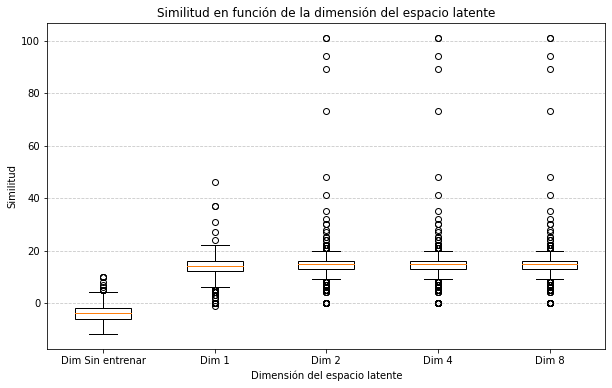

In [58]:
dims = ['Sin entrenar', 1, 2, 4, 8]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(similitud, labels=[f"Dim {dim}" for dim in dims], patch_artist=True)
for box in boxplot['boxes']:
    box.set(facecolor='white')
plt.title("Similitud en función de la dimensión del espacio latente")
plt.xlabel("Dimensión del espacio latente")
plt.ylabel("Similitud")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Interpretacion del modelo
Ejercicio 72. a) Utilizando el promedio sobre el eje de las diferentes secuencias elija los valores
medios en el espacio latente para generar la distribución de probabilidades de los aminoácidos
en cada posición. Recuerde que la salida del decoder para obtener la distribución de
probabilidades normalizada hay que aplicarle softmax.
Compare la distribución de probabilidades de los aminoácidos en cada posición para un modelo
sin entrenar, y para un modelo entrenado utilizando la media del vector latente de todas las
secuencias. Luego haga lo mismo para cada uno de los grupos N,O,P y si quiere también el
grupo Q.

In [60]:
my_nn.eval()
with torch.no_grad():
    latent_vectors = my_nn.encoder(seqs_one_hot)
latent_vectors.shape

torch.Size([2009, 8, 203])

In [93]:
mu = latent_vectors.mean(dim=0, keepdim=True)
mu.shape

torch.Size([1, 8, 203])

In [94]:
with torch.no_grad():
    decoded = my_nn.decoder(mu)
prob_dist = torch.softmax(decoded, dim=1)
prob_dist.shape

torch.Size([1, 21, 203])

In [21]:
def logo(prob_dist, start, end):
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY-")
    prob_df = pd.DataFrame(prob_dist.squeeze().numpy().T, columns=amino_acids)
    prob_df = prob_df.drop(columns=['-']) # Remove the gap column
    prob_df=prob_df.iloc[start:(end+1)]
    # Define the color scheme
    color_scheme = {
    'A': '#FF0000', # Red
    'R': '#00FF00', # Green
    'N': '#0000FF', # Blue
    'D': '#FFFF00', # Yellow
    'C': '#FF00FF', # Magenta
    'Q': '#00FFFF', # Cyan
    'E': '#FF8000', # Orange
    'G': '#8000FF', # Purple
    'H': '#FFFF80', # Light Yellow
    'I': '#800000', # Dark Red
    'L': '#008000', # Dark Green
    'K': '#000080', # Dark Blue
    'M': '#808000', # Olive
    'F': '#800080', # Dark Magenta
    'P': '#808080', # Gray
    'S': '#00FF80', # Light Green
    'T': '#008080', # Teal
    'W': '#FFFFFF', # White
    'Y': '#FF80FF', # Pink
    'V': '#FFD700', # Gold
    '-': '#000000', # Black for gaps
    }
    # Apply the color scheme to the logo
    logo = logomaker.Logo(prob_df, color_scheme=color_scheme)
    # Show the logo
    plt.show()

In [26]:
epochs = 50
my_nn = MSAAutoencoder(seq_length=seqs_one_hot.shape[2], latent_dim=4)
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
losses = []
for epoch in range(epochs):
    loss = train(my_nn, optimizer, criterion, dataloader)
    losses.append(loss)
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")
        similitud = np.array([calcular_similitud(seqs[j], one_hot_to_AA(my_nn(seqs_one_hot[j]).detach().numpy())) for j in range(len(seqs))])
        print(np.mean(similitud))

Epoch 0/50, Loss: 2.4351
-0.04430064708810354
Epoch 10/50, Loss: 0.0573
10.521154803384768
Epoch 20/50, Loss: 0.0081
14.094574415131907
Epoch 30/50, Loss: 0.0019
14.538078646092583
Epoch 40/50, Loss: 0.0005
14.630164260826282


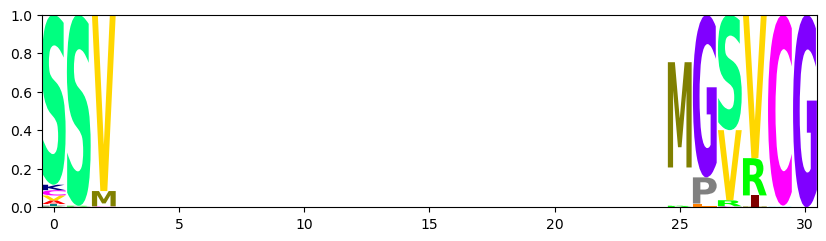

In [29]:
my_nn.eval()
with torch.no_grad():
    latent_vectors = my_nn.encoder(seqs_one_hot)
mu = latent_vectors.mean(dim=0, keepdim=True)
with torch.no_grad():
    decoded = my_nn.decoder(mu)
prob_dist = torch.softmax(decoded, dim=1)
logo(prob_dist, 0, 30)

# Por grupos

In [31]:
def leer_fasta_grupos(filepath):
    grupos = {'N': [], 'O': [], 'P': [], 'Q': []}
    
    for record in SeqIO.parse(filepath, "fasta"):
        primera_letra = record.id[0].upper()
        if primera_letra in grupos:
            grupos[primera_letra].append(str(record.seq))
    
    return grupos

In [37]:
grupos = leer_fasta_grupos("./NOPQ_cur.fasta")
OHE = {key: torch.tensor(one_hot_encoding(grupos[key])) for key in grupos}

Epoch 0/50, Loss: 2.0395
Sequence similarity: -3.1860795454545454
Epoch 10/50, Loss: 0.0086
Sequence similarity: 13.251420454545455
Epoch 20/50, Loss: 0.0007
Sequence similarity: 13.690340909090908
Epoch 30/50, Loss: 0.0002
Sequence similarity: 13.704545454545455
Epoch 40/50, Loss: 0.0001
Sequence similarity: 13.704545454545455


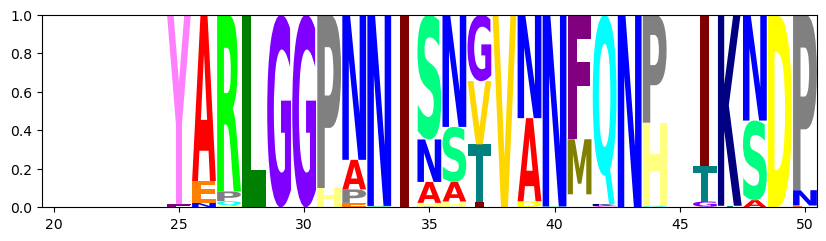

Epoch 0/50, Loss: 2.2082
Sequence similarity: -1.1589648798521257
Epoch 10/50, Loss: 0.0170
Sequence similarity: 15.388170055452864
Epoch 20/50, Loss: 0.0025
Sequence similarity: 16.262476894639555
Epoch 30/50, Loss: 0.0009
Sequence similarity: 16.44916820702403
Epoch 40/50, Loss: 0.0003
Sequence similarity: 16.515711645101664


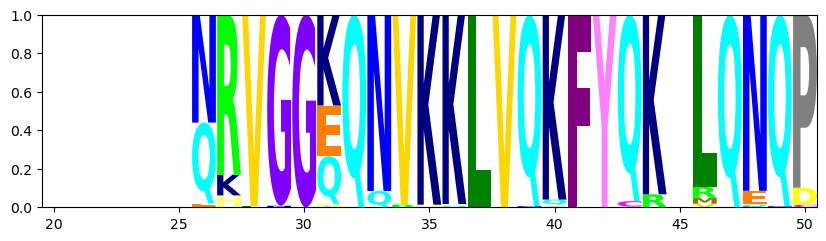

Epoch 0/50, Loss: 2.0312
Sequence similarity: -4.154494382022472
Epoch 10/50, Loss: 0.0036
Sequence similarity: 13.308988764044944
Epoch 20/50, Loss: 0.0005
Sequence similarity: 13.46629213483146
Epoch 30/50, Loss: 0.0002
Sequence similarity: 13.49438202247191
Epoch 40/50, Loss: 0.0001
Sequence similarity: 13.49438202247191


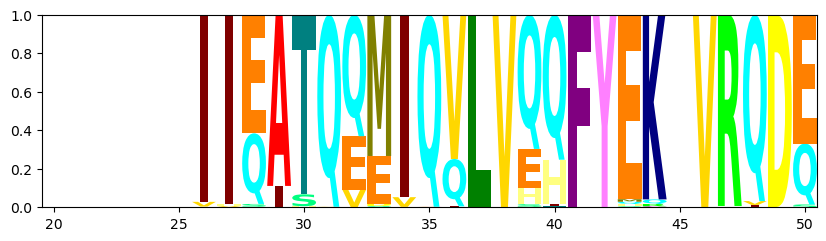

Epoch 0/50, Loss: 3.0164
Sequence similarity: 0.0
Epoch 10/50, Loss: 2.1349
Sequence similarity: -0.06666666666666667
Epoch 20/50, Loss: 1.3363
Sequence similarity: 5.7555555555555555
Epoch 30/50, Loss: 0.8100
Sequence similarity: 9.333333333333334
Epoch 40/50, Loss: 0.4670
Sequence similarity: 12.733333333333333


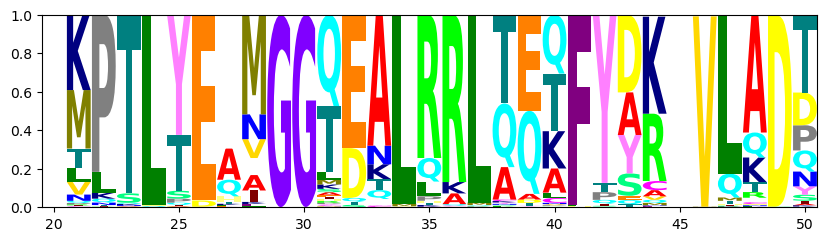

In [46]:
for key in OHE:
  
    epochs = 50
    my_nn = MSAAutoencoder(seq_length=OHE[key].shape[2], latent_dim=4)
    optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    y_true_indices = torch.argmax(OHE[key], dim=1)
    dataset = TensorDataset(OHE[key], y_true_indices)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
  
    for epoch in range(epochs):
        loss = train(my_nn, optimizer, criterion, dataloader)
        if (epoch) % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")
            similitud = np.array([calcular_similitud(grupos[key][j], one_hot_to_AA(my_nn(OHE[key][j]).detach().numpy())) for j in range(len(grupos[key]))])
            print(f"Sequence similarity: {np.mean(similitud)}")

    my_nn.eval()
    
    with torch.no_grad():
        latent_vectors = my_nn.encoder(OHE[key])
    mu = latent_vectors.mean(dim=0, keepdim=True)
    
    with torch.no_grad():
        decoded = my_nn.decoder(mu)
    prob_dist = torch.softmax(decoded, dim=1)
    logo(prob_dist, 20, 50)

72b) Ahora, utilizando una dimensión latente de dos, Promedie a lo largo del eje de todas las
posiciones de las secuencias y obtenga de este modo un punto en en el espacio latente para
cada una de las secuencias. Grafique esos puntos para todas las secuencias coloreadas de
acuerdo al grupo al que pertenecen. Analice los resultados.

In [ ]:
all_latents = []
all_labels = []

X_all = []
y_all = []
group_labels = []

for key in OHE:
    X_all.append(OHE[key])
    y_all.append(torch.argmax(OHE[key], dim=1))  
    group_labels.extend([key] * OHE[key].shape[0])

X_all = torch.cat(X_all, dim=0)  
y_all = torch.cat(y_all, dim=0)

dataset = TensorDataset(X_all, y_all)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

epochs = 50
my_nn = MSAAutoencoder(seq_length=X_all.shape[2], latent_dim=2)
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    loss = train(my_nn, optimizer, criterion, dataloader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

my_nn.eval()
with torch.no_grad():
    latent_vectors = my_nn.encoder(X_all)  # shape: (n, 2, seq_len)
    mean_tensor = latent_vectors.mean(dim=2)  # shape: (n, 2)
    all_latents = mean_tensor.numpy()
    all_labels = np.array(group_labels)


Epoch 0/50, Loss: 1.3857
Epoch 10/50, Loss: 0.0013
Epoch 20/50, Loss: 0.0014
Epoch 30/50, Loss: 0.0004
Epoch 40/50, Loss: 0.0279


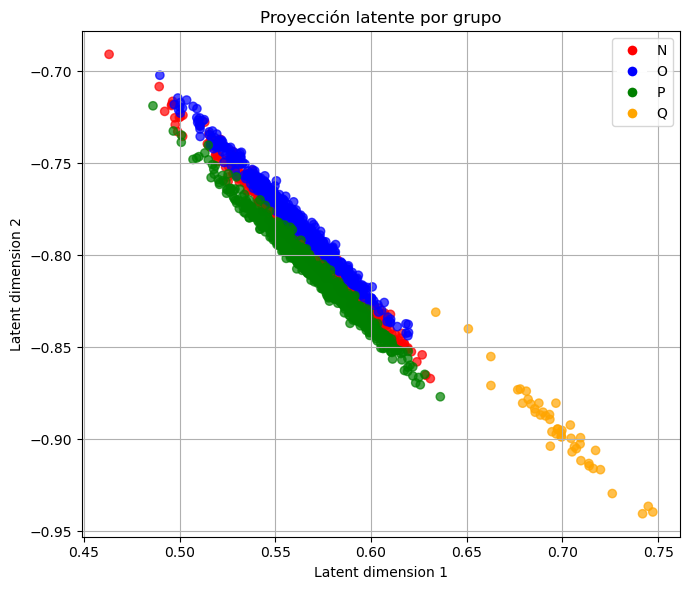

In [50]:
colores = {'N': 'red', 'O': 'blue', 'P': 'green', 'Q': 'orange'}
colors = [colores[k] for k in all_labels]

plt.figure(figsize=(7, 6))
plt.scatter(all_latents[:, 0], all_latents[:, 1], c=colors, alpha=0.7)
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.title("Proyección latente por grupo")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=k,
                               markerfacecolor=v, markersize=8) for k, v in colores.items()])
plt.grid(True)
plt.tight_layout()
plt.show()

c) Una mejor manera de analizar el espacio latente, es realizar sobre el mismo (ya sea en 2, o
más dimensiones) un PCA. Esto permite agrupar las secuencias de acuerdo a como se
distribuyen en el espacio latente de una manera optima. Aplique entonces PCA al resultado del
espacio latente (promediadio sobre L), grafique y análice los resultados.

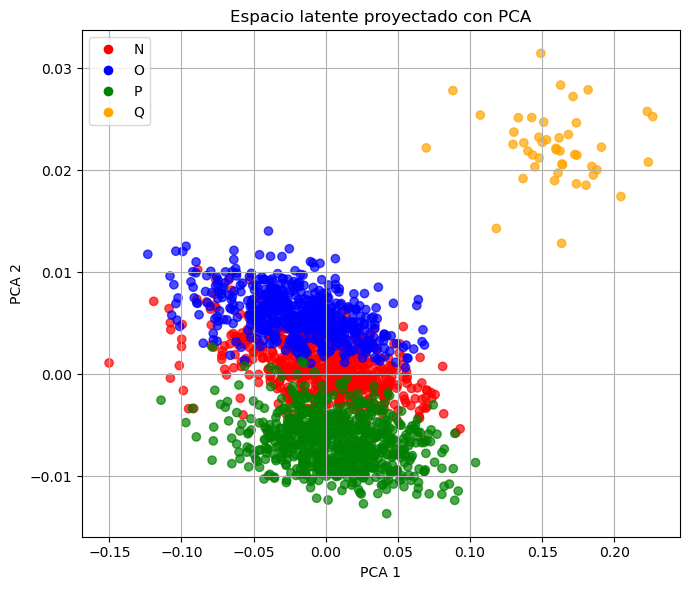

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latents_pca = pca.fit_transform(all_latents)


plt.figure(figsize=(7, 6))
plt.scatter(latents_pca[:, 0], latents_pca[:, 1], c=colors, alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Espacio latente proyectado con PCA")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=k,
                               markerfacecolor=v, markersize=8) for k, v in colores.items()])
plt.grid(True)
plt.tight_layout()
plt.show()